In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# MURA

In [2]:
import sys
sys.path.append("../../fastai/")

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix

In [4]:
# See how many devices are around
torch.cuda.device_count()
# Set it to a particular device
torch.cuda.set_device(0)
# Check which device you are on
torch.cuda.current_device()

0

In [5]:
PATH = "/home/sathiesh/Deep_Learning_Kaliy/my_projects/mura-v1.1/data/"  #MMIV
#PATH = "/Users/Sathiesh/MachineLearning/Deep_Learning_Kaliy/my_projects/mura/data/" #Home

In [6]:
cleaned_label_path = f'{PATH}cleaned_label.csv'

In [7]:
df_train_image_paths = pd.read_csv(f'{PATH}train_image_paths.csv',header=None)
df_train_labeled_studies = pd.read_csv(f'{PATH}train_labeled_studies.csv', header=None)

In [8]:
df_train_image_paths.columns = ['Image Index']

In [9]:
df_train_labeled_studies.columns = ['Image Index', 'Abnormality']

In [10]:
df_train_labeled_studies.head()

,Image Index,Abnormality
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1


In [11]:
#finne indeksen 
df_train_image_paths['Abnormality'] = np.nan

In [12]:
df_train_image_paths.head()

,Image Index,Abnormality
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,NaN
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,NaN
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,NaN
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,NaN
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,NaN


In [13]:
total = 0; 
for index, row in df_train_labeled_studies.iterrows():
    studie_name = row['Image Index']
    studie_abnormality = row['Abnormality']
    
    df = df_train_image_paths['Image Index'].str.contains(studie_name)
    df = df[df]
    
    idx_list = list(df.index)
    df_train_image_paths.ix[idx_list, 'Abnormality'] = studie_abnormality      
    total = total + len(idx_list);

/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


In [14]:
df_train_image_paths.shape, total

((36808, 2), 36808)

In [17]:
df_train_image_paths.head()

,Image Index,Abnormality
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1.0
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1.0
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1.0
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1.0
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1.0


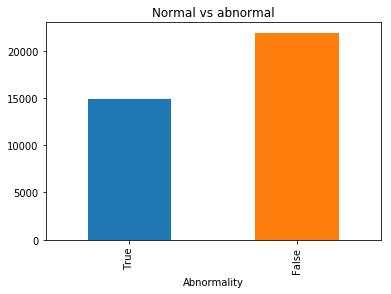

In [19]:
df_sorted = df_train_image_paths.pivot_table(index='Abnormality', aggfunc=len).sort_values('Image Index') 
#df_sorted.index = [disease_name,'Other']
df_sorted['Image Index'].plot(kind='bar', title="Normal vs abnormal")

In [21]:
df_train_image_paths.to_csv(cleaned_label_path, index=False)

# Load cleaned label

In [7]:
df_train_image_paths = pd.read_csv(cleaned_label_path)

In [8]:
n = len(df_train_image_paths)-1
val_idxs = get_cv_idxs(n, val_pct=0.15) 

In [9]:
len(val_idxs)

5521

In [10]:
df_train_image_paths.shape

(36808, 2)

# View data

In [11]:
sz = 64
arch = dn121
bs = 16

In [12]:
def get_data(sz): 
    tfms = tfms_from_model(arch, sz, aug_tfms=RandomFlip())
  #transforms_side_on
    return ImageClassifierData.from_csv(PATH ,'', cleaned_label_path , test_name='test', tfms=tfms, bs=bs, val_idxs = val_idxs);

In [13]:
data = get_data(sz)

In [14]:
fn = PATH+data.trn_ds.fnames[10]

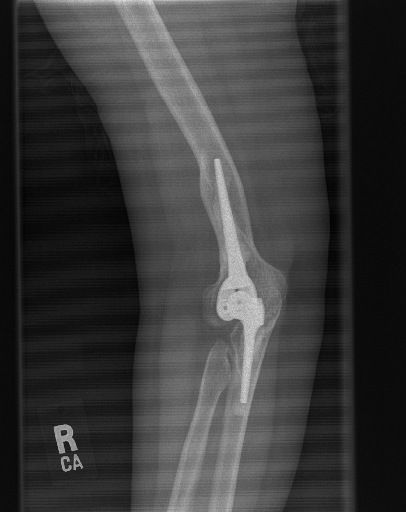

In [15]:
img = PIL.Image.open(fn);
img

In [16]:
data.trn_ds.fnames.shape ,data.val_ds.fnames.shape

((31287,), (5521,))

# Training

In [17]:
learn = ConvLearner.pretrained(arch, data, ps = 0.4, opt_fn=optim.Adam) 

 66%|██████▋   | 1299/1956 [06:40<03:22,  3.24it/s, loss=2.89] 

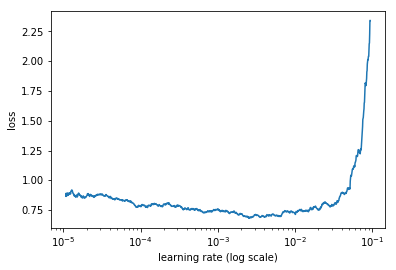

 66%|██████▋   | 1299/1956 [07:00<03:32,  3.09it/s, loss=2.89]

In [25]:
learn.lr_find()
learn.sched.plot()

In [18]:
lr = 0.0001

In [19]:
learn.fit(lr,2, cycle_len=1, cycle_mult=2) 

epoch      trn_loss   val_loss   accuracy                      
    0      0.681736   0.582805   0.695888  
    1      0.624732   0.561734   0.715631                      
    2      0.615097   0.55782    0.714001                      



[array([0.55782]), 0.714001086759645]

In [20]:
lrs = [lr/9, lr/3, lr] #TODO uten TL bør jeg dele på 9 og 3
learn.unfreeze()

In [21]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}dn121')

epoch      trn_loss   val_loss   accuracy                      
    0      0.638429   0.569962   0.70585   
    1      0.560944   0.533821   0.742076                      
    2      0.547775   0.527447   0.742619                      



In [22]:
sz = 128

In [23]:
learn.set_data(get_data(sz))
learn.freeze()

In [24]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.585745   0.530612   0.735012  
    1      0.588462   0.52196    0.747328                      
    2      0.537313   0.51953    0.747691                      



[array([0.51953]), 0.7476906357543923]

In [25]:
learn.unfreeze();
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.501611   0.481032   0.78301   
    1      0.498836   0.460044   0.789712                      
    2      0.451117   0.446852   0.801123                      



[array([0.44685]), 0.8011229849664916]

In [26]:
learn.save(f'{sz}dn121')

In [27]:
sz = 299

In [28]:
learn.set_data(get_data(sz))
learn.freeze() 

In [29]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.50839    0.476035   0.784097  
    1      0.524918   0.466209   0.789893                      
    2      0.494267   0.463537   0.790618                      



[array([0.46354]), 0.7906176417315703]

In [30]:
learn.unfreeze()
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}dn121')

epoch      trn_loss   val_loss   accuracy                      
    0      0.47389    0.436246   0.809093  
    1      0.437648   0.418061   0.81833                       
    2      0.395317   0.409586   0.822677                      



In [31]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}1')

epoch      trn_loss   val_loss   accuracy                      
    0      0.454441   0.40654    0.825575  
    1      0.424529   0.408168   0.825394                      
    2      0.386234   0.406828   0.827567                      



# Prediction on test set

In [158]:
data = get_data(sz=299)
learn = ConvLearner.pretrained(arch, data, ps = 0.4, opt_fn=optim.Adam) 
learn.load("2991")

In [159]:
df_test = pd.read_csv(f'{PATH}valid_image_paths.csv', header=None)
df_test.columns = ['Image Index']

In [160]:
len(data.test_ds.fnames)

3197

In [161]:
df_test.head()

,Image Index
0,test/XR_WRIST/patient11185/study1_positive/ima...
1,test/XR_WRIST/patient11185/study1_positive/ima...
2,test/XR_WRIST/patient11185/study1_positive/ima...
3,test/XR_WRIST/patient11185/study1_positive/ima...
4,test/XR_WRIST/patient11186/study1_positive/ima...


In [162]:
df_test.shape

(3197, 1)

In [163]:
df_test['Image Index'] = df_test['Image Index'].str.replace("/", "_")
df_test['Image Index'] = df_test['Image Index'].str.replace("test_","test/")

In [164]:
df_test.head()

,Image Index
0,test/XR_WRIST_patient11185_study1_positive_ima...
1,test/XR_WRIST_patient11185_study1_positive_ima...
2,test/XR_WRIST_patient11185_study1_positive_ima...
3,test/XR_WRIST_patient11185_study1_positive_ima...
4,test/XR_WRIST_patient11186_study1_positive_ima...


In [165]:
patient_study_idxs = {}
for stud in df_test['Image Index']:
    study_name = stud[:-11]  #eksempel: studyname = test/XR_FOREARM_patient12044_study1_positive
    if study_name not in patient_study_idxs: 
        indices = [i for i, s in enumerate(data.test_ds.fnames) if study_name in s] #posisjonen til alle som 
        patient_study_idxs[study_name] = indices

In [166]:
len(patient_study_idxs)

1200

In [167]:
patient_study_y_label = {}
for key, value in patient_study_idxs.items():
    y_string = ([x.strip() for x in key.split('_')][-1])
    y=0
    if y_string == 'positive': y=1
    patient_study_y_label[key] = y

### Predict studies 

In [168]:
trn_tfms, val_tfms = tfms_from_model(arch, sz) # get transformations
def predict_abnormality(fn): 
    im = open_image(fn)
    im_val = val_tfms(im)
    preds = learn.predict_array(im_val[None])
    return np.argmax(preds)

In [169]:
#value inneholder alle indeksene til et studie 
study_prediction_dict = {}
for key, value in patient_study_idxs.items(): 
    prediction_list = []
    
    for img_pos in value: 
        prediction = predict_abnormality(PATH+data.test_ds.fnames[img_pos])
        prediction_list.append(prediction)
    study_prediction_dict[key] = max(prediction_list)

In [170]:
num_correct = 0;
wrong_prediction = {}
correct_prediction = {}
for key, value in study_prediction_dict.items(): 
    xr_type = ([x.strip() for x in key.split('_')][1]) #finne riktig 
    y = patient_study_y_label[key]
    if value == y: 
        num_correct +=1
        if xr_type not in correct_prediction: 
            correct_prediction[xr_type] = 1
        else: correct_prediction[xr_type] +=1
    else: 
        if xr_type  not in wrong_prediction: 
            wrong_prediction[xr_type] = 1
        else:wrong_prediction[xr_type] +=1

In [171]:
test_accuracy = num_correct/len(study_prediction_dict)

In [172]:
print("case study accuracy: "+str(test_accuracy))

case study accuracy: 0.8308333333333333


In [173]:
correct_prediction

{'WRIST': 208,
 'FOREARM': 112,
 'HAND': 137,
 'HUMERUS': 114,
 'SHOULDER': 152,
 'ELBOW': 134,
 'FINGER': 140}

In [174]:
wrong_prediction

{'WRIST': 29,
 'FOREARM': 22,
 'HAND': 30,
 'HUMERUS': 21,
 'SHOULDER': 42,
 'ELBOW': 24,
 'FINGER': 35}

In [175]:
cm = confusion_matrix(list(patient_study_y_label.values()),list(study_prediction_dict.values()));

[[573  89]
 [114 424]]


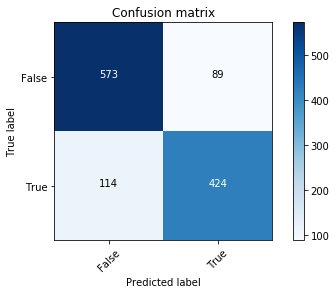

In [176]:
plot_confusion_matrix(cm, data.classes)

In [177]:
def cat_pred(correct, total): 
    return correct/total

In [178]:
for key,value in correct_prediction.items(): 
    total = value + wrong_prediction[key]
    acc = cat_pred(value, total)
    print("Accuracy for: " + key + ": " + str(acc) + "%")

Accuracy for: WRIST: 0.8776371308016878%
Accuracy for: FOREARM: 0.835820895522388%
Accuracy for: HAND: 0.8203592814371258%
Accuracy for: HUMERUS: 0.8444444444444444%
Accuracy for: SHOULDER: 0.7835051546391752%
Accuracy for: ELBOW: 0.8481012658227848%
Accuracy for: FINGER: 0.8%
